In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
rng = np.random.default_rng()

In [2]:
# Note -- place your own MNIST files in the appropriate directory
train_data = np.loadtxt("./data/mnist/mnist_train.csv", delimiter=',')
test_data = np.loadtxt("./data/mnist/mnist_test.csv", delimiter=',')

In [16]:
train_imgs = train_data[:, 1:]  # (60000, 784)
test_imgs = test_data[:, 1:]  # (10000, 784)
train_labels = train_data[:, 0]  # (60000, )
test_labels = test_data[:, 0]  # (10000, )

(60000, 784)

In [12]:
# Change the top k input values to 1, rest of the values to 0
def k_cap(input, cap_size):
    output = np.zeros_like(input)
    if len(input.shape) == 1:
        idx = np.argsort(input)[-cap_size:]
        output[idx] = 1
    else:
        idx = np.argsort(input, axis=-1)[:, -cap_size:]
        np.put_along_axis(output, idx, 1, axis=-1)
    return output

In [13]:
n_in = 784
n_neurons = 1000
cap_size = 100
sparsity = 0.1
n_rounds = 5
beta = 1e0

mask = np.zeros((n_neurons, n_neurons), dtype=bool)
W = np.zeros((n_neurons, n_neurons))
mask_a = np.zeros((n_in, n_neurons), dtype=bool)
A = np.zeros((n_in, n_neurons))

# Random mask on inter-area connections
# Choose 10% of connections and not the diagnal
mask = (rng.random((n_neurons, n_neurons)) < sparsity) & np.logical_not(np.eye(n_neurons, dtype=bool))
W = np.ones((n_neurons, n_neurons)) * mask
W /= W.sum(axis=0)

# Random mask on input-learning area connections
mask_a = rng.random((n_in, n_neurons)) < sparsity
A = np.ones((n_in, n_neurons)) * mask_a
A /= A.sum(axis=0)

In [14]:
print(W.shape, A.shape)

(1000, 1000) (784, 1000)


In [31]:
from scipy.signal import convolve

# k-cap on convolved input pixels
n_examples = 1000
train_examples = np.zeros((10, n_examples, 784))
for i in range(10):
    train_examples[i] = k_cap(convolve(train_imgs[train_labels == i][:n_examples].reshape(-1, 28, 28), 
                                 np.ones((1, 3, 3)), mode='same').reshape(-1, 28 * 28), 
                                 cap_size)

# some classes only have less than 1000 examples
n_test_examples = 890
test_examples = np.zeros((10, n_test_examples, 784))
for i in range(10):
    test_examples[i] = k_cap(convolve(test_imgs[test_labels == i][:n_test_examples].reshape(-1, 28, 28), 
                                 np.ones((1, 3, 3)), mode='same').reshape(-1, 28 * 28), 
                                 cap_size)

In [32]:
# Init connections from each neuron to sum up to 1
W = np.ones_like(W) * mask
A = np.ones_like(A) * mask_a
W /= W.sum(axis=0, keepdims=True)
A /= A.sum(axis=0, keepdims=True)
bias = np.zeros(n_neurons)
b = -1

# Loop over each class
for i in range(10):
    activations = np.zeros((n_rounds, n_neurons))
    act_h = np.zeros(n_neurons)
    
    # Loop over several examples
    for j in range(n_rounds):
        input = train_examples[i, j]  # (784, )
        
        # calculate activation
        act_h_new = k_cap(act_h @ W + input @ A + bias, cap_size)
        activations[j] = act_h_new.copy()
        
        # update weights
        A[(input > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
        W[(act_h > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
        
        act_h = act_h_new
        
    A /= A.sum(axis=0, keepdims=True)
    W /= W.sum(axis=0, keepdims=True)
        
    bias[act_h > 0] += b

In [44]:
# Test random weights
# Run the above cell instead for the trained weights
W = np.random.rand(n_neurons, n_neurons) * mask
A = np.random.rand(n_in, n_neurons) * mask_a
W /= W.sum(axis=0, keepdims=True)
A /= A.sum(axis=0, keepdims=True)
bias = np.zeros(n_neurons)

In [53]:
train_outputs = np.zeros((10, n_rounds+1, n_examples, n_neurons))
for i in np.arange(10):
    for j in range(n_rounds):
        # Run each example through the model n_round times
        train_outputs[i, j+1] = k_cap(train_outputs[i, j] @ W + train_examples[i] @ A, cap_size)
        
test_outputs = np.zeros((10, n_rounds+1, n_test_examples, n_neurons))
for i in np.arange(10):
    for j in range(n_rounds):
        # Run each example through the model n_round times
        test_outputs[i, j+1] = k_cap(test_outputs[i, j] @ W + test_examples[i] @ A, cap_size)

In [60]:
idx = np.full(n_neurons, -1, dtype=int)
act = train_outputs[:, -1].sum(axis=1)    # get outputs from after the last round and sum over examples?
print(act.shape)
print(act)

(10, 1000)
[[ 16.  77.  43. ...   6.  66.   1.]
 [ 11.  28.  40. ...   1.  45.   2.]
 [  5.  70.  21. ...  13.  24.   6.]
 ...
 [ 12.  57.  46. ...   6.  78.   1.]
 [  8.  51.  31. ...   6.  24.   2.]
 [ 11. 118.  79. ...  34.  84.   0.]]


In [61]:
for i, j in enumerate(range(10)):
    idx[i*cap_size:(i+1)*cap_size] = act[j].argsort()[-cap_size:][::-1]
    act[:, idx[i*cap_size:(i+1)*cap_size]] = -1

r = np.arange(n_neurons)
r[idx[idx > -1]] = -1
idx[(i+1)*cap_size:] = np.unique(r)[1:]

<IPython.core.display.Javascript object>


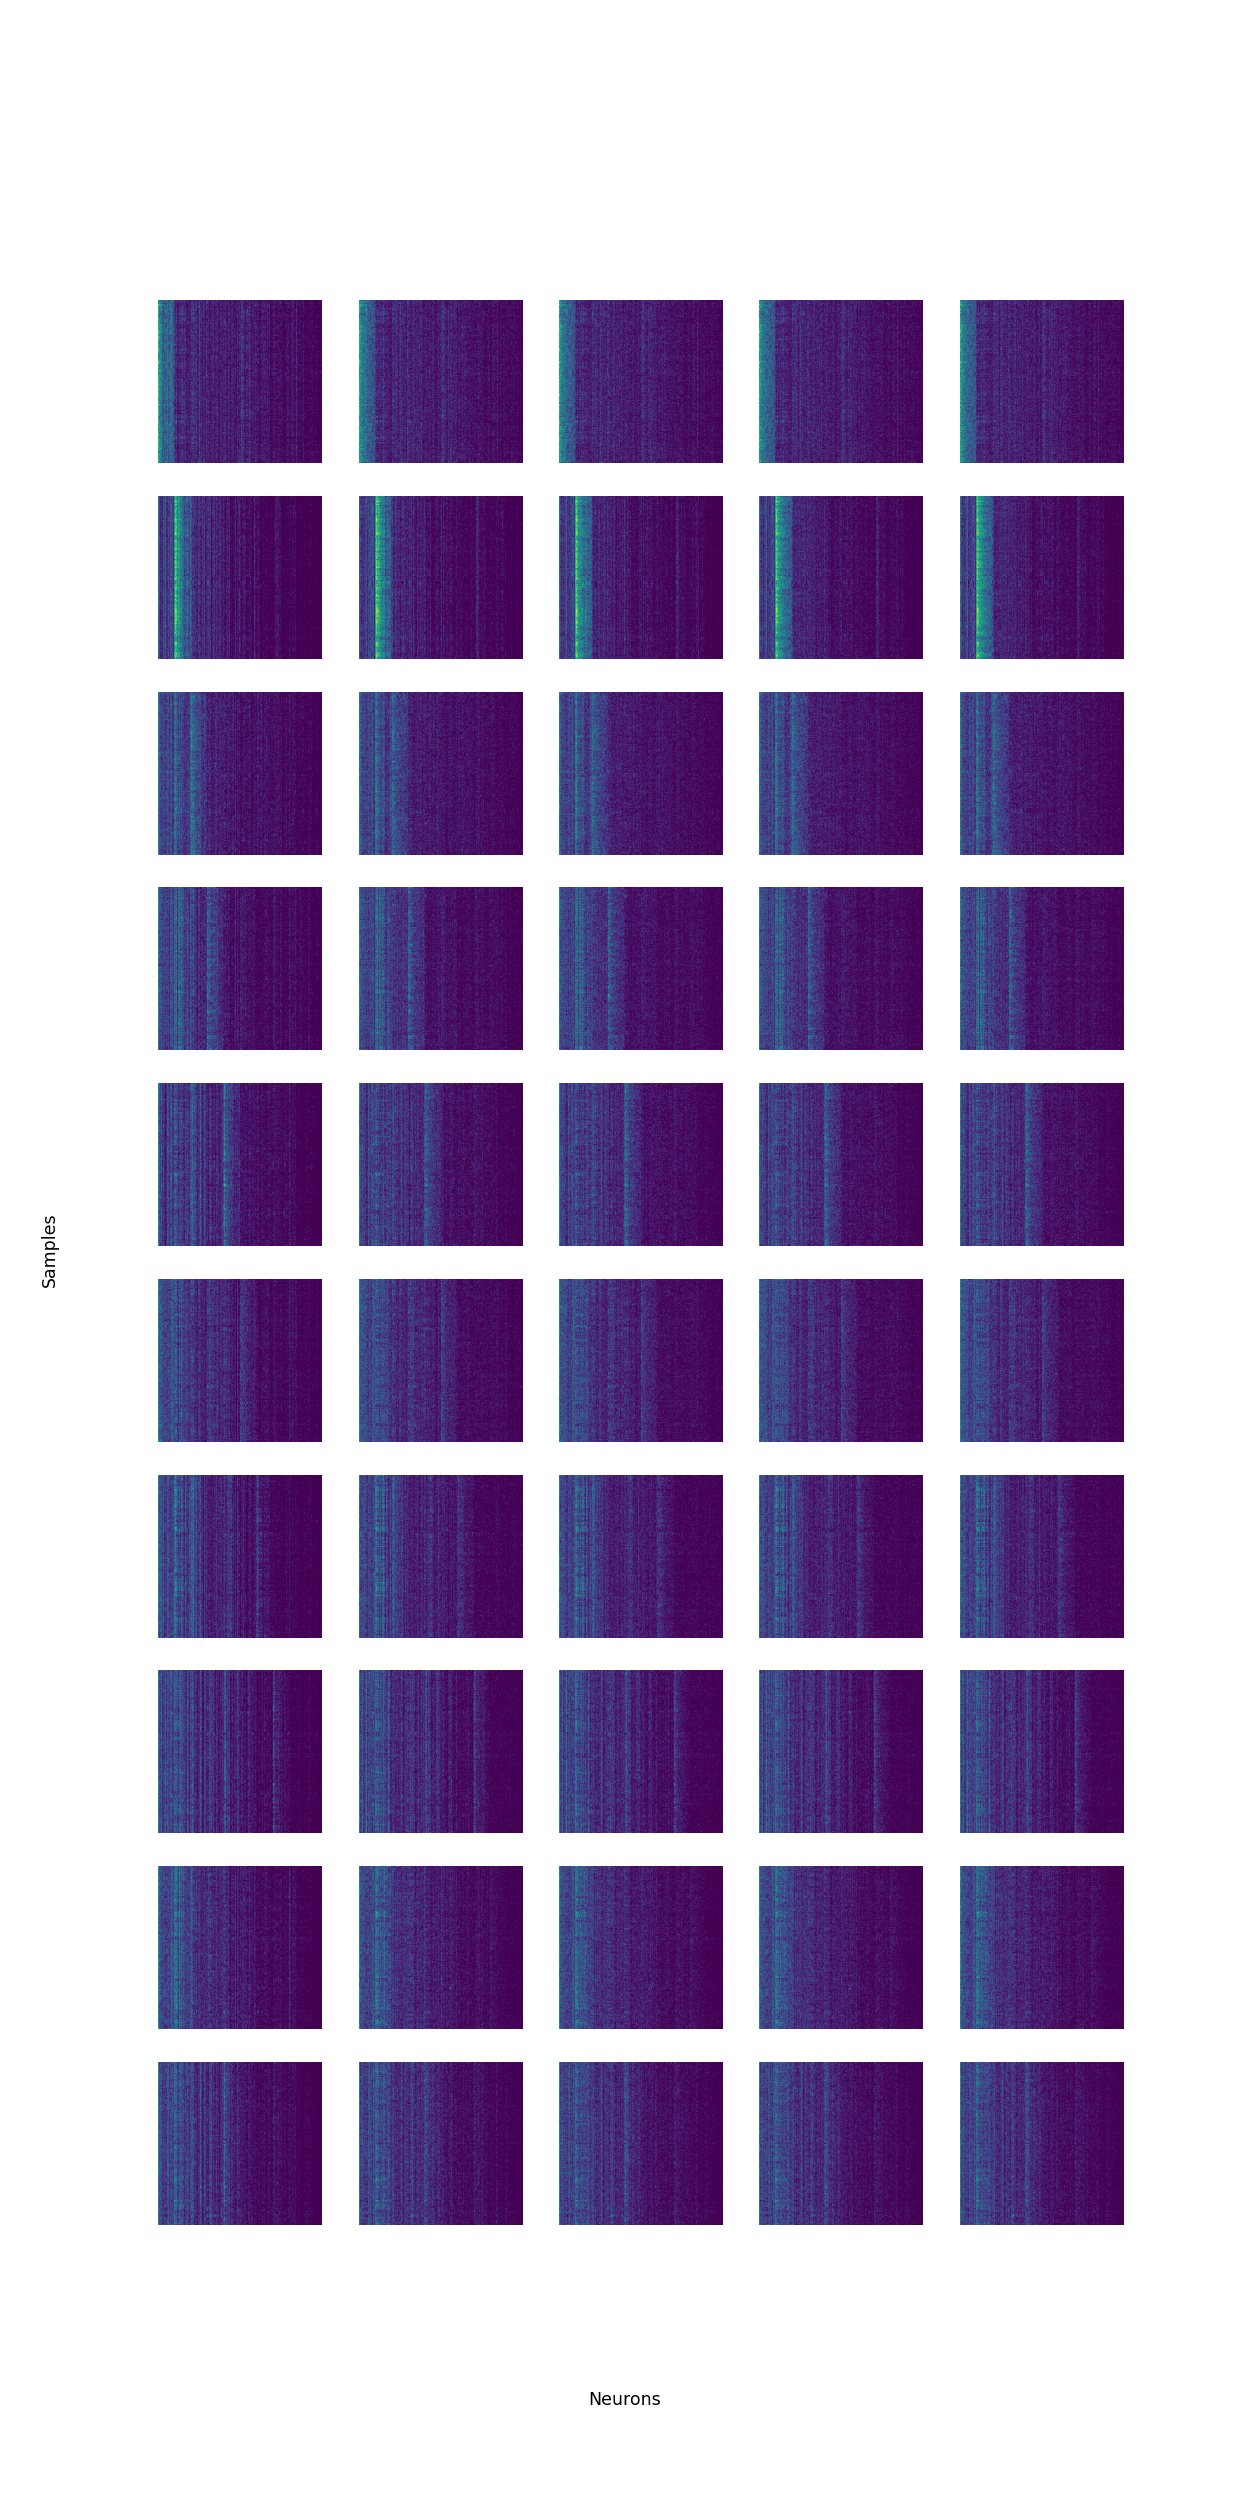

Text(0.04, 0.5, 'Samples')

In [62]:
fig, axes = plt.subplots(10, n_rounds, figsize=(10, 2 * 10), sharex=True, sharey=True)
for ax, output in zip(axes, train_outputs):
    for i in range(n_rounds):
        ax[i].imshow((output[i+1] > 0)[:, idx])
        ax[i].set_axis_off()
fig.text(0.5, 0.04, 'Neurons', ha='center', va='center')
fig.text(0.04, 0.5, 'Samples', ha='center', va='center', rotation='vertical')

<IPython.core.display.Javascript object>


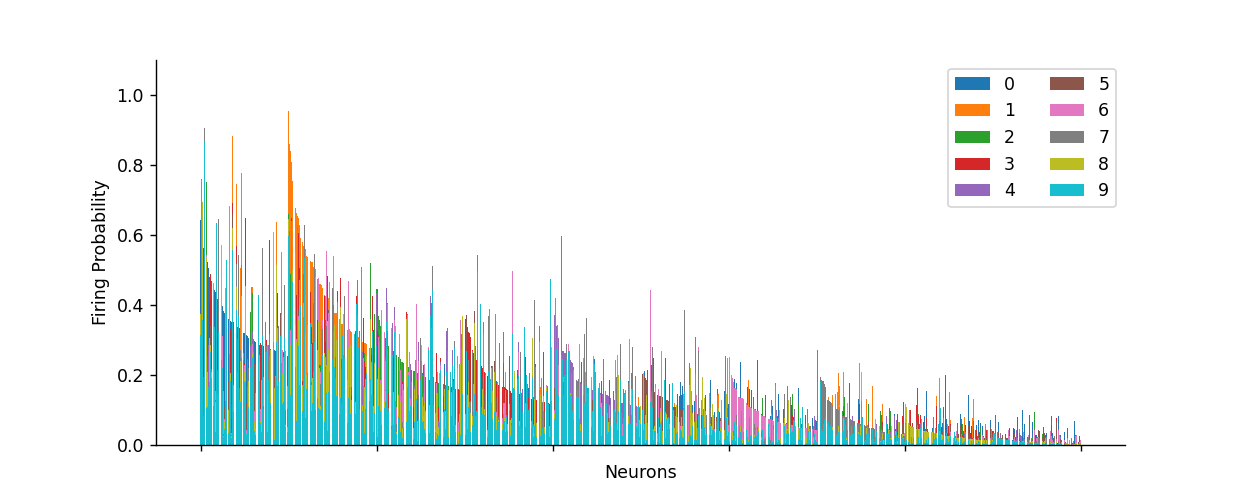

Text(0, 0.5, 'Firing Probability')

In [63]:
fig, ax = plt.subplots(figsize=(10, 4))
for i in range(10):
    ax.bar(np.arange(n_neurons), train_outputs[i, -1].mean(axis=0)[idx], label=i)
ax.legend(loc='upper right', ncol=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0, 1.1])
ax.set_xticklabels([])
ax.set_xlabel('Neurons')
ax.set_ylabel('Firing Probability')

In [64]:
# c is a mask for identifying each assembly
c = np.zeros((10, n_neurons))
for i in range(10):
    # set top k neurons to value 1 and 0 otherwise
    # based on the activation after 1 round of all the samples for each class
    # this is for finding the assemblies for each class
    # but it needs to see a lot of examples
    c[i, train_outputs[i, 1].sum(axis=0).argsort()[-cap_size:]] = 1

In [20]:
train_outputs[:, 1].shape, c.T.shape

((10, 1000, 1000), (1000, 10))

In [25]:
(train_outputs[:, 1] @ c.T).shape

(10, 1000, 10)

In [67]:
predictions = (train_outputs[:, 1] @ c.T).argmax(axis=-1)
train_acc = (predictions == np.arange(10)[:, np.newaxis]).sum(axis=-1) / n_examples

In [68]:
predictions = (test_outputs[:, 1] @ c.T).argmax(axis=-1)
test_acc = (predictions == np.arange(10)[:, np.newaxis]).sum(axis=-1) / n_test_examples

In [69]:
train_acc, test_acc

(array([0.901, 0.94 , 0.695, 0.778, 0.79 , 0.548, 0.74 , 0.803, 0.597,
        0.603]),
 array([0.9247191 , 0.93258427, 0.64719101, 0.82808989, 0.77977528,
        0.51235955, 0.68876404, 0.76741573, 0.6       , 0.62022472]))

In [23]:
predictions, np.arange(10)[:, np.newaxis]

(array([[0, 0, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [7, 7, 7, ..., 7, 7, 7],
        [8, 8, 8, ..., 1, 4, 2],
        [9, 1, 9, ..., 9, 9, 9]]),
 array([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]]))

<IPython.core.display.Javascript object>


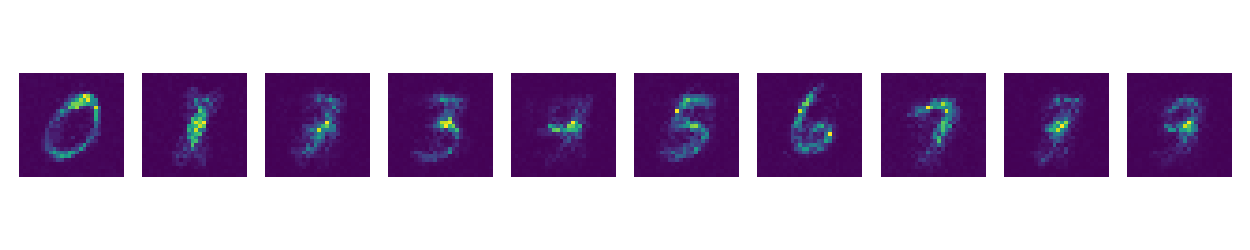

In [52]:
fig, axes = plt.subplots(1, 10, figsize=(10, 2))
for i in range(10):
    axes[i].imshow((A * c[i][np.newaxis, :]).sum(axis=1).reshape(28, 28))
    axes[i].set_axis_off()
fig.tight_layout()

In [17]:
n_in = 784
n_neurons = 2000
cap_size = 200
sparsity = 0.1
n_rounds = 5
beta = 1e0
mask = np.zeros((n_neurons, n_neurons), dtype=bool)
W = np.zeros((n_neurons, n_neurons))
mask_a = np.zeros((n_in, n_neurons), dtype=bool)
A = np.zeros((n_in, n_neurons))
mask = (rng.random((n_neurons, n_neurons)) < sparsity) & np.logical_not(np.eye(n_neurons, dtype=bool))
W = np.ones((n_neurons, n_neurons)) * mask
W /= W.sum(axis=0)
mask_a = rng.random((n_in, n_neurons)) < sparsity
A = np.ones((n_in, n_neurons)) * mask_a
A /= A.sum(axis=0)

In [18]:
n_trials = 20
accs = np.zeros((9, n_trials))
for k in range(n_trials):
    W = np.ones_like(W) * mask
    A = np.ones_like(A) * mask_a
    W /= W.sum(axis=0, keepdims=True)
    A /= A.sum(axis=0, keepdims=True)
    bias = np.zeros(n_neurons)
    b = -1
    for i in range(10):
        activations = np.zeros((n_rounds, n_neurons))
        act_h = np.zeros(n_neurons)
        for j in range(n_rounds):
            input = examples[i, rng.choice(n_examples)]
            act_h_new = k_cap(act_h @ W + input @ A + bias, cap_size)
            activations[j] = act_h_new.copy()
            A[(input > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
            W[(act_h > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
            act_h = act_h_new
        bias[act_h > 0] += b
        A /= A.sum(axis=0, keepdims=True)
        W /= W.sum(axis=0, keepdims=True)
        if i == 0:
            continue
        outputs = np.zeros((i+1, n_examples, n_neurons))
        c = np.zeros((10, n_neurons))
        for j in range(i+1):
            outputs[j] = k_cap(examples[j] @ A, cap_size)
            c[j, outputs[j].sum(axis=0).argsort()[-cap_size:]] = 1
        predictions = (outputs @ c.T).argmax(axis=-1)
        accs[i-1, k] = (predictions == np.arange(i+1)[:, np.newaxis]).sum() / (n_examples * (i+1))        

<IPython.core.display.Javascript object>


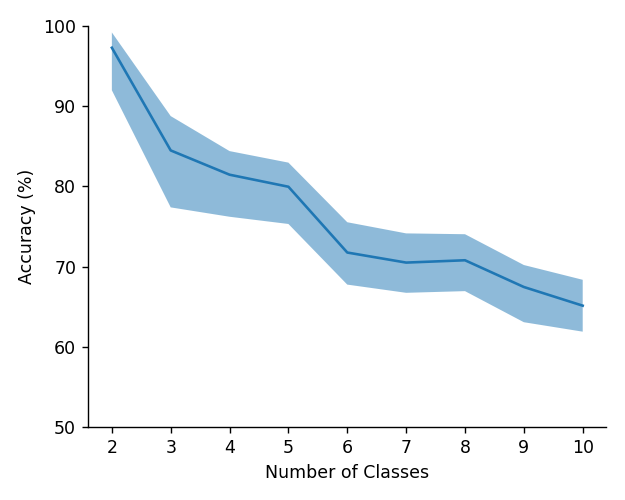

In [19]:
fig, ax = plt.subplots(figsize=(5, 4))
# ax.fill_between(np.arange(2, 11), 100 * accs.mean(axis=-1) - 100*accs.std(axis=-1), 100 * accs.mean(axis=-1) + 100*accs.std(axis=-1), alpha=0.5)
ax.fill_between(np.arange(2, 11), 100 * accs.min(axis=-1), 100 * accs.max(axis=-1), alpha=0.5)
ax.plot(np.arange(2, 11), 100 * accs.mean(axis=-1))
ax.set_xlabel(r'Number of Classes')
ax.set_ylabel('Accuracy (%)')
ax.set_ylim([50, 100])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()